# NucSegAI Result Analysis - Cell Type Quantification

This notebook analyzes NucSegAI JSON output files to extract:
- Cell counts by type
- Cell type proportions
- Type probability statistics

---

## Step 1: Import Required Libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Define Cell Type Dictionary

This mapping translates numeric cell type IDs to human-readable names.

In [3]:
# Cell type mapping
CELL_TYPE_DICT = {
    0: "Undefined",
    1: "Epithelium (PD-L1lo/Ki67lo)",
    2: "Epithelium (PD-L1hi/Ki67hi)",
    3: "Macrophage",
    4: "Lymphocyte",
    5: "Vascular",
    6: "Fibroblast/Stroma"
}

# Color mapping for visualization (converted from RGB to hex)
CELL_TYPE_COLORS = {
    0: "#000000",  # Black (RGB: 0, 0, 0) - Undefined
    1: "#387F39",  # Dark Green (RGB: 56, 127, 57) - Epithelium low
    2: "#00FF00",  # Bright Green (RGB: 0, 255, 0) - Epithelium high
    3: "#FC8D62",  # Coral/Salmon (RGB: 252, 141, 98) - Macrophage
    4: "#FFD92F",  # Yellow (RGB: 255, 217, 47) - Lymphocyte
    5: "#4535C1",  # Blue/Purple (RGB: 69, 53, 193) - Vascular
    6: "#17BECF"   # Cyan (RGB: 23, 190, 207) - Fibroblast/Stroma
}

print("Cell Type Mapping:")
for type_id, type_name in CELL_TYPE_DICT.items():
    print(f"  {type_id}: {type_name} -> {CELL_TYPE_COLORS[type_id]}")

Cell Type Mapping:
  0: Undefined -> #000000
  1: Epithelium (PD-L1lo/Ki67lo) -> #387F39
  2: Epithelium (PD-L1hi/Ki67hi) -> #00FF00
  3: Macrophage -> #FC8D62
  4: Lymphocyte -> #FFD92F
  5: Vascular -> #4535C1
  6: Fibroblast/Stroma -> #17BECF


## Step 3: Define Function to Analyze Single JSON File

This function reads a single JSON file and extracts all relevant statistics.

In [5]:
def analyze_single_json(json_path):
    """
    Analyze a single NucSegAI JSON output file.
    
    Parameters:
    -----------
    json_path : str or Path
        Path to the JSON file
    
    Returns:
    --------
    dict : Dictionary containing analysis results
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract nucleus data
    nuclei = data.get('nuc', {})
    
    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'total_cells': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'type_prob_stats': {}
        }
    
    # Initialize storage
    cell_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    
    # Extract data from each nucleus
    for nucleus_id, nucleus_data in nuclei.items():
        cell_type = nucleus_data.get('type', 0)
        type_prob = nucleus_data.get('type_prob', 0)
        
        cell_types.append(cell_type)
        type_probs.append(type_prob)
        type_probs_by_type[cell_type].append(type_prob)
    
    # Count cells by type
    cell_counts = Counter(cell_types)
    total_cells = len(cell_types)
    
    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells
    
    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min': np.min(type_probs) if type_probs else 0,
        'median': np.median(type_probs) if type_probs else 0,
        'mean': np.mean(type_probs) if type_probs else 0,
        'max': np.max(type_probs) if type_probs else 0,
        'std': np.std(type_probs) if type_probs else 0
    }
    
    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min': np.min(probs),
            'median': np.median(probs),
            'mean': np.mean(probs),
            'max': np.max(probs),
            'std': np.std(probs)
        }
    
    return {
        'filename': Path(json_path).name,
        'total_cells': total_cells,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type
    }

print("✅ Function defined: analyze_single_json()")

✅ Function defined: analyze_single_json()


## Step 4: Display Results Function

Create a function to display results in a readable format.

In [7]:
def display_results(results):
    """
    Display analysis results in a formatted way.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    print("="*80)
    print(f"Analysis Results for: {results['filename']}")
    print("="*80)
    print(f"\n📊 Total Cells Detected: {results['total_cells']:,}\n")
    
    # Cell Counts and Proportions
    print("─" * 80)
    print("Cell Type Distribution")
    print("─" * 80)
    print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>10}")
    print("─" * 80)
    
    for cell_type in sorted(results['cell_counts'].keys()):
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]
        percentage = proportion * 100
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>9.2f}%")
    
    # Overall Type Probability Statistics
    print("\n" + "─" * 80)
    print("Overall Type Probability Statistics")
    print("─" * 80)
    stats = results['type_prob_stats_overall']
    print(f"  Minimum:  {stats['min']:.10f}")
    print(f"  Median:   {stats['median']:.10f}")
    print(f"  Mean:     {stats['mean']:.10f}")
    print(f"  Maximum:  {stats['max']:.10f}")
    print(f"  Std Dev:  {stats['std']:.10f}")
    
    # Type Probability Statistics by Cell Type
    print("\n" + "─" * 80)
    print("Type Probability Statistics by Cell Type")
    print("─" * 80)
    
    for cell_type in sorted(results['type_prob_stats_by_type'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        stats = results['type_prob_stats_by_type'][cell_type]
        print(f"\n{type_name}:")
        print(f"  Min: {stats['min']:.6f} | Med: {stats['median']:.6f} | Mean: {stats['mean']:.6f} | Max: {stats['max']:.6f}")
    
    print("\n" + "="*80)

print("✅ Function defined: display_results()")

✅ Function defined: display_results()


## Step 5: Visualization Functions

In [8]:
def plot_cell_type_distribution(results):
    """
    Create visualizations for cell type distribution.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data
    cell_types = sorted(results['cell_counts'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    counts = [results['cell_counts'][ct] for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]
    
    # Bar plot
    axes[0].bar(cell_names, counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Cell Counts by Type\n{results["filename"]}', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    axes[1].pie(counts, labels=cell_names, colors=colors, autopct='%1.1f%%',
                startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
    axes[1].set_title(f'Cell Type Proportions\n{results["filename"]}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_type_probability_distribution(results):
    """
    Create violin plot for type probabilities by cell type.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    cell_types = sorted(results['type_prob_stats_by_type'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    
    # Prepare data for box plot
    stats_data = []
    for ct in cell_types:
        stats = results['type_prob_stats_by_type'][ct]
        stats_data.append([stats['min'], stats['median'], stats['mean'], stats['max']])
    
    # Create bar plot for mean values with error bars
    means = [results['type_prob_stats_by_type'][ct]['mean'] for ct in cell_types]
    stds = [results['type_prob_stats_by_type'][ct]['std'] for ct in cell_types]
    colors_list = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]
    
    bars = ax.bar(cell_names, means, yerr=stds, color=colors_list, 
                   edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)
    
    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Type Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Type Probability by Cell Type (Mean ± Std Dev)\n{results["filename"]}', 
                 fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


## Step 6: Analyze Single JSON File

**👉 Update the path below to point to your JSON file**

✅ File found: /mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json/tile_9880_35568.json
Analysis Results for: tile_9880_35568.json

📊 Total Cells Detected: 918

────────────────────────────────────────────────────────────────────────────────
Cell Type Distribution
────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion Percentage
────────────────────────────────────────────────────────────────────────────────
Undefined                                     35       0.0381      3.81%
Epithelium (PD-L1lo/Ki67lo)                   20       0.0218      2.18%
Epithelium (PD-L1hi/Ki67hi)                   51       0.0556      5.56%
Macrophage                                   105       0.1144     11.44%
Lymphocyte                                   374       0.4074     40.74%
Vascular                                      94       0.1024     10.24%
Fibroblast

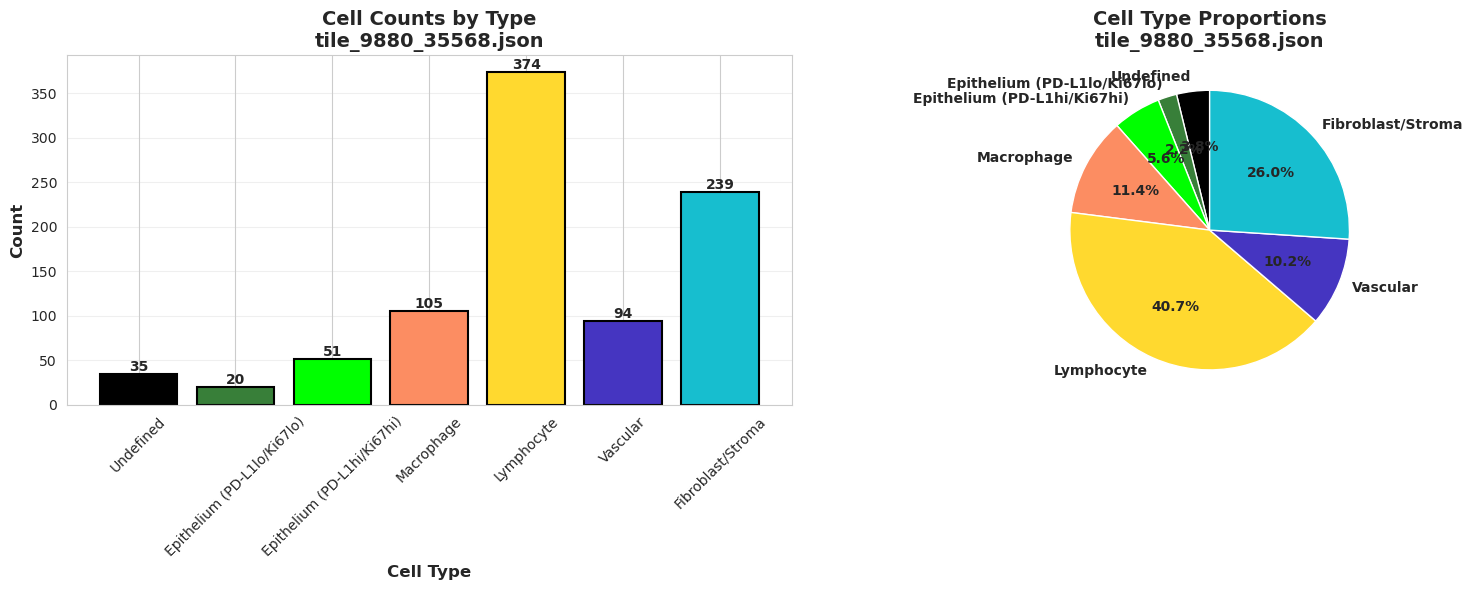

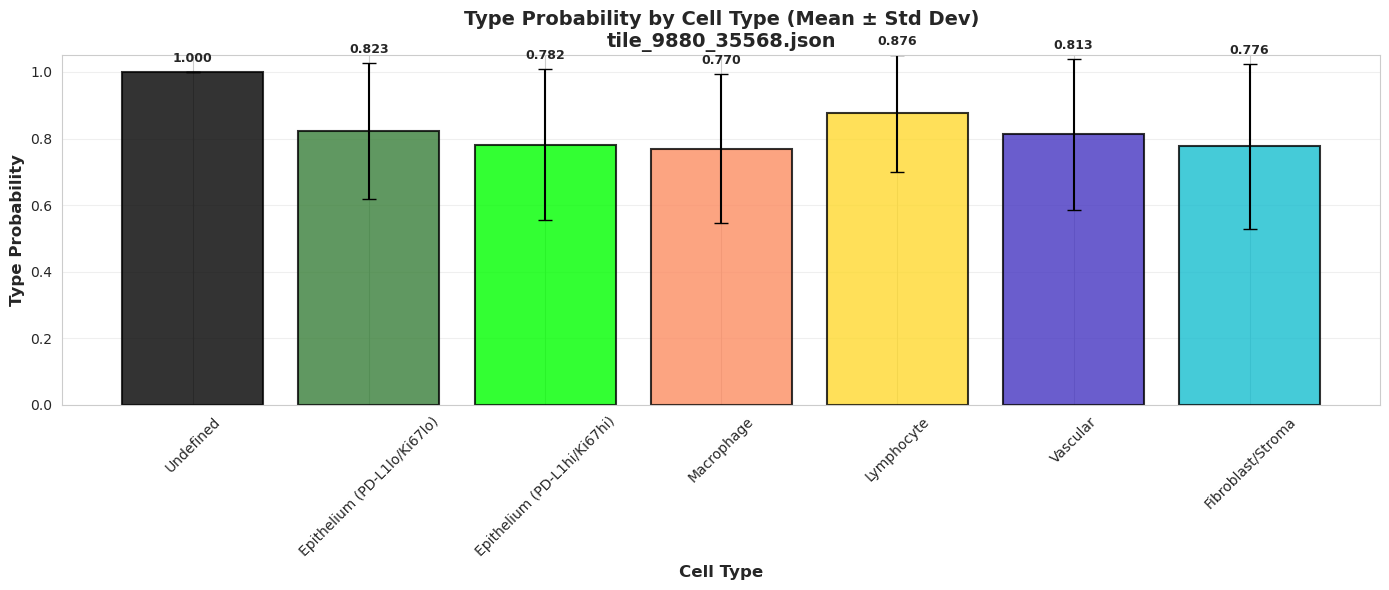

In [18]:
# ⚠️ UPDATE THIS PATH TO YOUR JSON FILE
json_file_path = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json/tile_9880_35568.json"  # Change this to your file path

# Check if file exists
if not Path(json_file_path).exists():
    print(f"❌ Error: File not found at {json_file_path}")
    print("Please update the json_file_path variable with the correct path.")
else:
    print(f"✅ File found: {json_file_path}")
    
    # Analyze the file
    results = analyze_single_json(json_file_path)
    
    # Display results
    display_results(results)
    
    # Create visualizations
    print("\n📊 Generating visualizations...\n")
    plot_cell_type_distribution(results)
    plot_type_probability_distribution(results)

## Step 7: Export Results to CSV/Excel (Optional)

In [ ]:
def export_results_to_csv(results, output_path="cell_analysis_results.csv"):
    """
    Export analysis results to CSV file.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    output_path : str
        Path for output CSV file
    """
    # Prepare data for DataFrame
    data_rows = []
    
    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]
        
        stats = results['type_prob_stats_by_type'][cell_type]
        
        data_rows.append({
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100,
            'TypeProb_Min': stats['min'],
            'TypeProb_Median': stats['median'],
            'TypeProb_Mean': stats['mean'],
            'TypeProb_Max': stats['max'],
            'TypeProb_Std': stats['std']
        })
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Results exported to: {output_path}")
    
    return df

# Export results
if 'results' in locals():
    df_results = export_results_to_csv(results)
    display(df_results)
else:
    print("⚠️ No results to export. Please run Step 6 first.")

## Step 8: Batch Analysis (All 122 JSON Files)

Process all JSON files in a directory and aggregate results.

In [20]:
def analyze_multiple_json_files(json_directory):
    """
    Analyze all JSON files in a directory.
    
    Parameters:
    -----------
    json_directory : str or Path
        Path to directory containing JSON files
    
    Returns:
    --------
    list : List of result dictionaries
    """
    json_dir = Path(json_directory)
    json_files = sorted(json_dir.glob("*.json"))
    
    if not json_files:
        print(f"❌ No JSON files found in {json_directory}")
        return []
    
    print(f"Found {len(json_files)} JSON files")
    print("Processing...\n")
    
    all_results = []
    
    for i, json_file in enumerate(json_files, 1):
        if i % 10 == 0:
            print(f"Processed {i}/{len(json_files)} files...")
        
        results = analyze_single_json(json_file)
        all_results.append(results)
    
    print(f"\n✅ Completed! Processed {len(json_files)} files.")
    return all_results

def aggregate_results(all_results):
    """
    Aggregate results from multiple JSON files.
    
    Parameters:
    -----------
    all_results : list
        List of result dictionaries
    
    Returns:
    --------
    dict : Aggregated statistics
    """
    total_cells_all = sum(r['total_cells'] for r in all_results)
    
    # Aggregate counts by cell type
    aggregated_counts = Counter()
    for result in all_results:
        for cell_type, count in result['cell_counts'].items():
            aggregated_counts[cell_type] += count
    
    # Calculate overall proportions
    aggregated_proportions = {}
    for cell_type, count in aggregated_counts.items():
        aggregated_proportions[cell_type] = count / total_cells_all
    
    return {
        'total_files': len(all_results),
        'total_cells': total_cells_all,
        'aggregated_counts': dict(aggregated_counts),
        'aggregated_proportions': aggregated_proportions
    }

# ⚠️ UPDATE THIS PATH TO YOUR JSON DIRECTORY
json_directory = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json"  # Change to your directory path

# Uncomment to run batch analysis
all_results = analyze_multiple_json_files(json_directory)
aggregated = aggregate_results(all_results)
print("\n" + "="*80)
print("AGGREGATED RESULTS (All 122 Files)")
print("="*80)
print(f"Total Files: {aggregated['total_files']}")
print(f"Total Cells: {aggregated['total_cells']:,}\n")
for cell_type, count in sorted(aggregated['aggregated_counts'].items()):
    type_name = CELL_TYPE_DICT[cell_type]
    proportion = aggregated['aggregated_proportions'][cell_type]
    print(f"{type_name:<35} {count:>12,} ({proportion*100:>6.2f}%)")

print("✅ Batch analysis functions defined")
#print("Uncomment the code above and update json_directory to run batch analysis")

Found 122 JSON files
Processing...

Processed 10/122 files...
Processed 20/122 files...
Processed 30/122 files...
Processed 40/122 files...
Processed 50/122 files...
Processed 60/122 files...
Processed 70/122 files...
Processed 80/122 files...
Processed 90/122 files...
Processed 100/122 files...
Processed 110/122 files...
Processed 120/122 files...

✅ Completed! Processed 122 files.

AGGREGATED RESULTS (All 122 Files)
Total Files: 122
Total Cells: 114,336

Undefined                                  5,371 (  4.70%)
Epithelium (PD-L1lo/Ki67lo)                8,877 (  7.76%)
Epithelium (PD-L1hi/Ki67hi)               30,464 ( 26.64%)
Macrophage                                 9,682 (  8.47%)
Lymphocyte                                25,208 ( 22.05%)
Vascular                                   8,724 (  7.63%)
Fibroblast/Stroma                         26,010 ( 22.75%)
✅ Batch analysis functions defined


## Summary

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Type probability statistics (min, median, mean, max)
4. ✅ Visualizations (bar charts, pie charts)
5. ✅ CSV export functionality
6. ✅ Batch processing for all 122 files

**Next Steps:**
- Use these counts for spatial analysis
- Compare distributions across different tissue regions
- Correlate with clinical outcomes

---
*Generated for NucSegAI Analysis Pipeline*